# Lab. 11: Integer Linear programming and Dinamic Programming

## Introduction

#### <u>In this lab, we will see Integer Linear programming and Dynamic programming (DP).</u>

In [306]:
# @title Helper Functions

!pip install -q pyscipopt
!pip install -q scikit-optimize
!pip install -q treed

from pyscipopt import Model, Eventhdlr, SCIP_EVENTTYPE
from pyscipopt import Model , quicksum
import matplotlib.pyplot as plt
from treed import TreeD
import networkx as nx
import seaborn as sns
import numpy as np
import pyscipopt
import math
import time
import copy

class LPstatEventhdlr(Eventhdlr):
    """PySCIPOpt Event handler to collect data on LP events."""

    transvars = {}

    def collectNodeInfo(self, firstlp=True):
        objval = self.model.getSolObjVal(None)

        LPsol = {}
        if self.transvars == {}:
            self.transvars = self.model.getVars(transformed=True)
        for var in self.transvars:
            solval = self.model.getSolVal(None, var)
            LPsol[var.name] = self.model.getSolVal(None, var)

        # skip duplicate nodes
        # if self.nodelist and LPsol == self.nodelist[-1].get("LPsol"):
        #     return
        node = self.model.getCurrentNode()
        if node.getNumber() != 1:
            parentnode = node.getParent()
            parent = parentnode.getNumber()
        else:
            parent = 1
        depth = node.getDepth()
        age = self.model.getNNodes()
        condition = math.log10(self.model.getCondition())
        iters = self.model.lpiGetIterations()
        pb = self.model.getPrimalbound()
        if pb >= self.model.infinity():
            pb = None

        nodedict = {
            "number": node.getNumber(),
            "LPsol": LPsol,
            "objval": objval,
            "parent": parent,
            "age": age,
            "depth": depth,
            "first": firstlp,
            "condition": condition,
            "iterations": iters,
            # "variables": self.model.getNVars(),
            # "constraints": self.model.getNConss(),
            "rows": self.model.getNLPRows(),
            "primalbound": pb,
            "dualbound": self.model.getDualbound(),
            "time": self.model.getSolvingTime()
        }

        self.nodelist.append(nodedict)

    def eventexec(self, event):

        if event.getType() == SCIP_EVENTTYPE.FIRSTLPSOLVED:
            self.collectNodeInfo(firstlp=True)
        elif event.getType() == SCIP_EVENTTYPE.LPSOLVED:
            self.collectNodeInfo(firstlp=False)
        else:
            print("unexpected event:" + str(event))
        return {}

    def eventinit(self):
        self.model.catchEvent(SCIP_EVENTTYPE.LPEVENT, self)

def convertSolToDict(sol):
    ssol = str(sol).replace('\'', '').replace('t_', '')
    items = ssol[1:-1].split(", ")
    res = {}
    for item in items:
        k = str(item.split(":")[0])
        v = float(item.split(":")[1])
        res[k] = v
    return res


#risolve già il problema per noi -> ciò che importa è la definizione del probelma
def solve_model(model):
    model.setPresolve(pyscipopt.SCIP_PARAMSETTING.OFF)
    model.setHeuristics(pyscipopt.SCIP_PARAMSETTING.OFF)
    model.disablePropagation()
    #model.redirectOutput()
    nodelist = []
    eventhdlr = LPstatEventhdlr()
    eventhdlr.nodelist = nodelist
    model.includeEventhdlr(
        eventhdlr, "LPstat", "generate LP statistics after every LP event"
    )
    model.optimize()
    frontier_history = []
    for nd in nodelist:
        frontier_history.append((convertSolToDict(nd['LPsol']), nd['objval']))
    best_sol = model.getBestSol()
    best_val = model.getObjVal()
    return convertSolToDict(best_sol), best_val, frontier_history

## Exercises

For the Integer Linear Programming, you will proceed as in the previous lab, writing some models and solving the problem. For Dynamic Programming, we will ask you to solve the knapsack problem with DP.

### Example exercise

Slack form:

minimize  $2x_1 + x_2 − 2x_3$

subject to

> $0.7x_1 + 0.5x_2 +x_3 ≥ 1.8$

> $x_i ∈ [0,1]\ ∀ i$

In [307]:
model = Model("")

# create three variables for x1, x2 and x3
x = {f"x_{i+1}": model.addVar(vtype='i', name=f"x_{i+1}",lb=0,ub=1) for i in range(3)}
print(x)
# array for coefficient in constraint
A = [0.7,0.5,1]

# quick sum is used for creating summing the variables times their coefficients:
# Ax >= b
# where A = [0.7, 0.5, 1], x = [x1, x2, x3], b = [1.8]
model.addCons(quicksum(A[i]*x[f"x_{i+1}"] for i in range(3))>=1.8)

# set the objective minimize c'x
# where c' indicates the array c = [2, 1, -2] transposed
c = [2, 1, -2]
model.setObjective(quicksum(c[i]*x[f"x_{i+1}"] for i in range(3)), "minimize")

best_sol, best_val, partial_frontier_history = solve_model(model)

print("Best solution", best_sol)
print("Best value", best_val)
print("\n---Partial frontier history---\n")
for hist in partial_frontier_history:
  print("solution:", hist[0], "\t\tvalue:", hist[1])

{'x_1': x_1, 'x_2': x_2, 'x_3': x_3}
Best solution {'x_1': 1.0, 'x_2': 1.0, 'x_3': 1.0}
Best value 1.0

---Partial frontier history---

solution: {'x_1': 0.42857142857142866, 'x_2': 1.0, 'x_3': 1.0} 		value: -0.14285714285714268
solution: {'x_1': 1.0, 'x_2': 1.0, 'x_3': 1.0} 		value: 1.0


### Exercise 1/3: The N-queens Problem | ILP


The N queens puzzle is the problem of placing N chess queens on an $N×N (𝑁≥4)$ chessboard so that no two queens threaten each other; thus, a solution requires that no two queens share the same row, column, or diagonal. Try different values of $𝑁$ and shows how the problem complexity increases.

---

#### **HINT:**

*Maximize the number of the queen placed in the chessboard, subject to the constraint of no threatening*

||&nbsp; &nbsp; A&nbsp; &nbsp;|&nbsp; &nbsp; B&nbsp; &nbsp;|&nbsp; &nbsp; C&nbsp; &nbsp;|&nbsp; &nbsp; D&nbsp; &nbsp;|
|-|-|-|-|-|
|**1**|$ x_{1,1} $|$ x_{1,2} $|$ x_{1,3} $|$ x_{1,4} $|
|**2**|$ x_{2,1} $|$ x_{2,2} $|$ x_{2,3} $|$ x_{2,4} $|
|**3**|$ x_{3,1} $|$ x_{3,2} $|$ x_{3,3} $|$ x_{3,4} $|
|**4**|$ x_{4,1} $|$ x_{4,2} $|$ x_{4,3} $|$ x_{4,4} $|

>N = queens number

maximize $\Sigma_{i=1}^N \Sigma_{j=1}^N x_{i,j}$\
subject to
>$\Sigma_{j=1}^N x_{1,j} = 1$ at most one queen in row 1\
>$\Sigma_{j=1}^N x_{2,j} = 1$ at most one queen in row 2\
>$\Sigma_{j=1}^N x_{3,j} = 1$ at most one queen in row 3\
>$\Sigma_{j=1}^N x_{4,j} = 1$ at most one queen in row 4

>$\Sigma_{i=1}^N x_{i,1} = 1$ at most one queen in column 1 (A)\
>$\Sigma_{i=1}^N x_{i,2} = 1$ at most one queen in column 2 (B)\
>$\Sigma_{i=1}^N x_{i,3} = 1$ at most one queen in column 3 (C)\
>$\Sigma_{i=1}^N x_{i,4} = 1$ at most one queen in column 4 (D)

>$\Sigma_{j=1}^{N-2} x_{j+2, j} <= 1$ at most one queen in diagonal A3 to B4\
>$\Sigma_{j=1}^{N-1} x_{j+1, j} <= 1$ at most one queen in diagonal A2 to C4

>$\Sigma_{j=1}^{N} x_{j, j} <= 1$ at most one queen in diagonal A1 to D4\
>$\Sigma_{j=1}^{N-1} x_{j, j+1} <= 1$ at most one queen in diagonal B1 to D3\
>$\Sigma_{j=1}^{N-2} x_{j, j+2} <= 1$ at most one queen in diagonal C1 to D2

>$\Sigma_{j=1}^{N-2} x_{j, N-1-j}$ at most one queen in diagonal A2 to B1\
>$\Sigma_{j=1}^{N-1} x_{j, N-j}$ at most one queen in diagonal A3 to C1\
>$\Sigma_{j=1}^{N} x_{j, N+1-j}$ at most one queen in diagonal A4 to D1

>$\Sigma_{j=2}^{N} x_{j, N+2-j}$ at most one queen in diagonal B4 to D2\
>$\Sigma_{j=3}^{N} x_{j, N+2-j}$ at most one queen in diagonal C4 to D3


In [308]:
import numpy as np

def get_NQueens_model(N):
    model = Model("")
    v = {f"x_{i}{j}": model.addVar(vtype='i', name=f"x_{i}{j}",lb=0,ub=1) for i in range(1,N+1) for j in range(1,N+1)}


    #constraints sulle righe
    for i in range(1,N+1):
        model.addCons(quicksum(1*v[f"x_{i}{j}"] for j in range(1,N+1))==1)



    #constraints sulle colonne
    for j in range(1,N+1):
        model.addCons(quicksum(1*v[f"x_{i}{j}"] for i in range(1,N+1))==1)
        

    #constraints sulle diagonali
    for righe in range(1,N+1):
        for colonne in range(1,N+1):
            num_ite1 = N + 1 - max(righe, colonne)
            num_ite2 = 1 - min(righe, colonne)
            num_ite3 = min(N - righe, colonne - 1) 
            num_ite4 = min(righe - 1, N - colonne)
            model.addCons(quicksum(1*v[f"x_{righe+i}{colonne+i}"] for i in range(num_ite2,num_ite1))<=1)
            lista1 = [(righe + i, colonne - i) for i in range(num_ite3 + 1)]
            # Iterazioni che vanno dal centro verso il basso a sinistra
            lista2 = [(righe - i, colonne + i) for i in range(1, num_ite4 + 1)]
            lista = lista1 + lista2
            model.addCons(quicksum(1*v[f"x_{i[0]}{i[1]}"] for i in lista)<=1)


    for i in range(1,N+1):
        model.setObjective(quicksum(1*v[f"x_{i}{j}"] for j in range(1,N+1)), "maximize")

    return model

In [309]:
n_queens = 7  # TODO : experiment with the number of queens
model = get_NQueens_model(n_queens)
initial_time = time.time()
best_sol, best_val, partial_frontier_history = solve_model(model)
print(f"elapsed time: {time.time() - initial_time}")

print("Best solution", best_sol)
print("Best value", best_val)

for i in range(1, n_queens+1):
  line = []
  for j in range(1, n_queens+1):
    line.append('Q' if best_sol[f"x_{i}{j}"]==1 else '-')
  print(line)

elapsed time: 0.07229089736938477
Best solution {'x_11': 0.0, 'x_12': 0.0, 'x_13': 0.0, 'x_14': 0.0, 'x_15': 1.0, 'x_16': 0.0, 'x_17': 0.0, 'x_21': 0.0, 'x_22': 1.0, 'x_23': 0.0, 'x_24': 0.0, 'x_25': 0.0, 'x_26': 0.0, 'x_27': 0.0, 'x_31': 0.0, 'x_32': 0.0, 'x_33': 0.0, 'x_34': 0.0, 'x_35': 0.0, 'x_36': 1.0, 'x_37': 0.0, 'x_41': 0.0, 'x_42': 0.0, 'x_43': 1.0, 'x_44': 0.0, 'x_45': 0.0, 'x_46': 0.0, 'x_47': 0.0, 'x_51': 0.0, 'x_52': 0.0, 'x_53': 0.0, 'x_54': 0.0, 'x_55': 0.0, 'x_56': 0.0, 'x_57': 1.0, 'x_61': 0.0, 'x_62': 0.0, 'x_63': 0.0, 'x_64': 1.0, 'x_65': 0.0, 'x_66': 0.0, 'x_67': 0.0, 'x_71': 1.0, 'x_72': 0.0, 'x_73': 0.0, 'x_74': 0.0, 'x_75': 0.0, 'x_76': 0.0, 'x_77': 0.0}
Best value 1.0
['-', '-', '-', '-', 'Q', '-', '-']
['-', 'Q', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', 'Q', '-']
['-', '-', 'Q', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', 'Q']
['-', '-', '-', 'Q', '-', '-', '-']
['Q', '-', '-', '-', '-', '-', '-']


### Exercise 2/3: Traveling Salesman Problem | ILP

The goal of the TSP is to find the shortest Hamiltonian cycle (a cycle that visits each node only once) on a graph of N nodes. Solve the ILP problem and visualize a solution.

Try to model the problem from this [link](https://phabi.ch/2021/10/08/solving-tsp-with-linear-programming-and-google-or-tools/)

### Indices:
$i, j \in I = 1,2,3,....,n$\
$n$ = number of nodes

### Decision variables:
$x_{i,j}$ = 1 if node j is visited right after node i, 0 otherwise

### Auxiliary variables:
$u_i$ it enumerate the stops in sequential order, used for the subtour elimination constraint

### Parameters:
$d_{i,j}$ = distance to reach node j from node i (and viceversa)

### Constraints:
Leave every point for exactly one successor\
$\forall i \in I : \Sigma_{j} x_{i,j} = 1$

Reach every point from exactly one predecessor\
$\forall j \in I : \Sigma_{i} x_{i,j} = 1$


*For the following constraints see [2.2. The MTZ Formulation](https://epubs.siam.org/doi/pdf/10.1137/S00361445023685) for a further explanation*

Start at the first node\
$u_1 = 1$

Since we have $n$ locations, all subsequent $u_i$ must have assigned a value between 2 and $n$\
$\forall i \ne 1 : 2 \le u_i \le n$

The index of every succeeding stop gets assigned an index which is at least 1 larger than the predecessor’s index\
$\forall i \ne 1, \forall j \ne 1 : u_i - u_j + 1 \le (n-1)(1-x_{i,j})$

### Objective Function:
minimize $\Sigma_{(i,j)\in(I \times I)} x_{i,j}d_{i,j}$

In [314]:
# randomly create a distance matrix defining the distance to reach node j from node i
# Since our problem is symmetrical, the vaues in the distance matrix are symmetrical with respect to the diagonal
def create_distance_matrix(num_nodes):
  distance = np.zeros((num_nodes, num_nodes))
  for i in range(num_nodes):
    for j in range(i+1, num_nodes):
        rand = np.round(np.random.rand(), 2)
        distance[i][j] = rand
        distance[j][i] = rand
  return distance

def get_directed_graph_from_weight_matrix(matrix, n_nodes):
    G = nx.DiGraph()
    G.add_nodes_from([i for i in range(1, n_nodes+1)])
    for i in range(n_nodes):
        for j in range(n_nodes):
            if(matrix[i][j] > 0):
              G.add_edge(i+1, j+1, weight=matrix[i][j])
    return G

def draw_graph(matrix, n_nodes, solution = None):
    print(solution)
    G = get_directed_graph_from_weight_matrix(matrix, n_nodes)
    pos = nx.circular_layout(G)
    edge_color = 'k'
    if(solution is not None):
      edge_color = []
      for i in range(n_nodes):
        for j in range(n_nodes):
          if(matrix[i][j]>0):
            edge_color.append("red" if solution[f"x_{i+1}{j+1}"]==1 else "black")
    nx.draw(G, pos, with_labels=True, connectionstyle='arc3,rad=0.15', edge_color=edge_color)
    edge_labels = dict(((u, v), "{start}->{end} w:{weight:.2f}".format(start=u, end=v, weight=d["weight"])) for u, v, d in G.edges(data=True))
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, label_pos=0.7, font_size=8)
    plt.show()

In [311]:
'''def get_TSP_model(matrix, n_nodes):
    model = Model("")
    print(matrix)
    v = {f"x_{i}{j}": model.addVar(vtype='i', name=f"x_{i}{j}",lb=0,ub=1) for i in range(1,n_nodes+1) for j in range(1,n_nodes+1)}
    u = {f"u_{i}": model.addVar(vtype='i', name=f"u_{i}",lb=2,ub=n_nodes) for i in range(1,n_nodes+1) }


    #Leave every point for exactly one successor
    for j in range(1,n_nodes+1):
        model.addCons(quicksum(1*v[f"x_{i}{j}"] for i in range(1,n_nodes+1))==1)

    #Reach every point from exactly one predecessor
    for i in range(1,n_nodes+1):
        model.addCons(quicksum(1*v[f"x_{i}{j}"] for j in range(1,n_nodes+1))==1)
    

    for i in range(1,n_nodes+1):
        if i == 1:
            model.addCons((1*u[f"u_{i}"]) ==1)
    
    for i in range(1,n_nodes+1):
        for j in range(1,n_nodes+1):
            if i != 1 and j!=1:
                print((u[f"u_{i}"] - u[f"u_{j}"] + 1) <= ((n_nodes - 1)*(1 - v[f"x_{i}{j}"])))
                model.addCons((u[f"u_{i}"] - u[f"u_{j}"] + 1) <= ((n_nodes - 1)*(1 - v[f"x_{i}{j}"])))

    d = matrix
    #[print(i) for i in d[0]]
    print(d)
                
    for i in range(1,n_nodes+1): 
        print(quicksum(v[f"x_{i}{j}"]*d[i-1][j-1] for j in range(1,n_nodes+1)))
        model.setObjective(quicksum(v[f"x_{i}{j}"]*d[i-1][j-1] for j in range(1,n_nodes+1)), "minimize")

    return model'''

'def get_TSP_model(matrix, n_nodes):\n    model = Model("")\n    print(matrix)\n    v = {f"x_{i}{j}": model.addVar(vtype=\'i\', name=f"x_{i}{j}",lb=0,ub=1) for i in range(1,n_nodes+1) for j in range(1,n_nodes+1)}\n    u = {f"u_{i}": model.addVar(vtype=\'i\', name=f"u_{i}",lb=2,ub=n_nodes) for i in range(1,n_nodes+1) }\n\n\n    #Leave every point for exactly one successor\n    for j in range(1,n_nodes+1):\n        model.addCons(quicksum(1*v[f"x_{i}{j}"] for i in range(1,n_nodes+1))==1)\n\n    #Reach every point from exactly one predecessor\n    for i in range(1,n_nodes+1):\n        model.addCons(quicksum(1*v[f"x_{i}{j}"] for j in range(1,n_nodes+1))==1)\n    \n\n    for i in range(1,n_nodes+1):\n        if i == 1:\n            model.addCons((1*u[f"u_{i}"]) ==1)\n    \n    for i in range(1,n_nodes+1):\n        for j in range(1,n_nodes+1):\n            if i != 1 and j!=1:\n                print((u[f"u_{i}"] - u[f"u_{j}"] + 1) <= ((n_nodes - 1)*(1 - v[f"x_{i}{j}"])))\n                model

In [312]:
def get_TSP_model(matrix, n_nodes):
    model = Model("TSP")
    x  = {f"x_{i}{j}": model.addVar(vtype='i', name=f"x_{i}{j}",lb=0,ub=1) for i in range(1,n_nodes+1) for j in range(1,n_nodes+1)}
    u = {f"u_1": model.addVar(vtype='C', name=f"u_1", lb=1, ub=1)}
    u.update({f"u_{i}": model.addVar(vtype='C', name=f"u_{i}", lb=2, ub=n_nodes) for i in range(2, n_nodes+1)})
    
    # Leave every point for exactly one successor
    for i in range(1, n_nodes+1):
        model.addCons(quicksum(x[f"x_{i}{j}"] for j in range(1, n_nodes+1)) == 1)

    # Reach every point from exactly one predecessor
    for j in range(1, n_nodes+1):
        model.addCons(quicksum(x[f"x_{i}{j}"] for i in range(1, n_nodes+1)) == 1)


    # Subtour elimination constraints
    for i in range(2, n_nodes+1):
        for j in range(2, n_nodes+1):
            model.addCons(u[f"u_{i}"] - u[f"u_{j}"] + n_nodes * x[f"x_{i}{j}"] <= n_nodes - 1)

    # Objective function
    model.setObjective(quicksum(x[f"x_{i}{j}"] * matrix[i-1][j-1] for i in range(1, n_nodes+1) for j in range(1, n_nodes+1)), "minimize")

    return model


Best solution {'x_11': 0.0, 'x_12': 0.0, 'x_13': 1.0, 'x_14': 0.0, 'x_21': 1.0, 'x_22': 0.0, 'x_23': 0.0, 'x_24': 0.0, 'x_31': 0.0, 'x_32': 0.0, 'x_33': 0.0, 'x_34': 1.0, 'x_41': 0.0, 'x_42': 1.0, 'x_43': 0.0, 'x_44': 0.0, 'u_1': 1.0, 'u_2': 4.0, 'u_3': 2.0, 'u_4': 3.0}
Best value 1.93
None


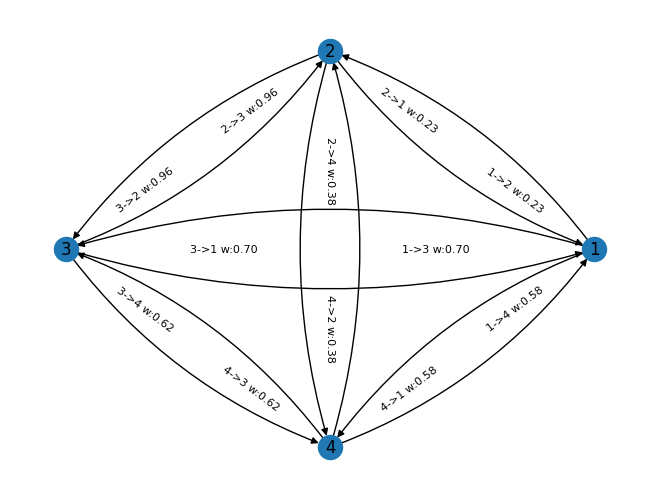

{'x_11': 0.0, 'x_12': 0.0, 'x_13': 1.0, 'x_14': 0.0, 'x_21': 1.0, 'x_22': 0.0, 'x_23': 0.0, 'x_24': 0.0, 'x_31': 0.0, 'x_32': 0.0, 'x_33': 0.0, 'x_34': 1.0, 'x_41': 0.0, 'x_42': 1.0, 'x_43': 0.0, 'x_44': 0.0, 'u_1': 1.0, 'u_2': 4.0, 'u_3': 2.0, 'u_4': 3.0}


KeyError: 'e_12'

In [315]:
n_nodes = 4 #number of nodes

matrix = create_distance_matrix(n_nodes)

model = get_TSP_model(matrix, n_nodes)
best_sol, best_val, partial_frontier_history = solve_model(model)

print("Best solution", best_sol)
print("Best value", best_val)

draw_graph(matrix, n_nodes)

draw_graph(matrix, n_nodes, best_sol)
# TODO: run draw_graph(matrox, n_nodes, solution=best_sol) after the get_TSP_model function is implemented

### Exercise 3/3: Knapsack Problem | DP

Solve the Knapsack problem using DP.  You can use the Class from lab 5.

Run the solution multiple time, and change the total capacity and the number of objects and show how the number of subproblems changes.

In [ ]:
class Knapsack_0_1:
    def __init__(self, capacity = 10, items = [
            {'name': 'apple', 'value': 1, 'volume': 2},
            {'name': 'pear', 'value': 2, 'volume': 2},
            {'name': 'banana', 'value': 2, 'volume': 2},
            {'name': 'watermelon', 'value': 5, 'volume': 10},
            {'name': 'orange', 'value': 3, 'volume': 2},
            {'name': 'avocado', 'value': 3, 'volume': 2},
            {'name': 'blueberry', 'value': 3, 'volume': 1},
            {'name': 'coconut', 'value': 4, 'volume': 3},
            {'name': 'cherry', 'value': 2, 'volume': 1},
            {'name': 'apricot', 'value': 1, 'volume': 1}
        ]):
        self._items = items
        self._BAG_CAPACITY = capacity

    def getCapacity(self):
        return self._BAG_CAPACITY

    def getItemsNumber(self):
        return len(self._items)

    def getWeightandValue(self, ind):
        w_i = self._items[ind]["volume"]
        c_i = self._items[ind]["value"]
        return (w_i, c_i)

    def _get_value(self, solution):
        cur_cap = self._BAG_CAPACITY
        cur_val = 0
        for i, v in enumerate(solution):
            if v == 1:
                cur_val += self._items[i]['value']
                cur_cap -= self._items[i]['volume']
            if cur_cap < 0:
                return 0
        return cur_val

    def __call__(self, solution):
        value = self._get_value(solution)
        return value

In [ ]:
def dp_solution(problem):
  K = problem.getCapacity()
  n = problem.getItemsNumber()
  v = np.zeros((K+1, n+1))
  S = np.zeros((K+1, n+1))
  sub_problem = 0

  # TODO

  pass

In [ ]:
problem = Knapsack_0_1()
sol, value, sub_problem = dp_solution(problem)
print("Solution", sol)
print("Value", value)
print("Subproblem number", sub_problem)

In [ ]:
# TODO : try with different parameters (capacity, items)